### Import Packages

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, exists
import pymysql

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle


### Cleaning data

#### Connect to database

In [2]:
# Read sensitive information from environment variables
api_key = os.getenv('OPENWEATHERMAP_API_KEY', "5b103a5aa9cd52cd178d63c3c83ad6ec")
db_username = os.getenv('DB_USERNAME', 'admin')
db_password = os.getenv('DB_PASSWORD', 'qwerty123')
db_name = os.getenv('DB_NAME', 'dublinbikes')
db_endpoint = os.getenv('DB_ENDPOINT', 'dublinbikes.ch2g8eocy1o4.eu-west-1.rds.amazonaws.com')
db_port = os.getenv('DB_PORT', '3306')


# Construct the database connection URL, using pymysql as the driver for the MySQL database
database_url = f"mysql+pymysql://{db_username}:{db_password}@{db_endpoint}:{db_port}/{db_name}"

# Attempt to create the database engine and connect
try:
    db = create_engine(database_url)
    conn = db.connect()
    print("Connected to the database successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

Connected to the database successfully.


#### Get data

In [3]:
# withdraw data
query_station = "SELECT * FROM station"
query_availability = "SELECT * FROM availability"
query_weather = "SELECT * FROM weather"

df_station = pd.read_sql_query(query_station, db)
df_availability = pd.read_sql_query(query_availability, db)
df_weather = pd.read_sql_query(query_weather, db)

#### Weather Table

In [4]:
# 1. check data
print(df_weather.head())
print(df_weather.info())
print(df_weather.describe())

# 2. clean data
# only save columns we need
columns_to_keep = ['weather_main', 'weather_description', 'temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'last_update']
df_weather = df_weather[columns_to_keep]
# delete duplicate rows
df_weather.drop_duplicates(inplace=True)

# Fill in or remove missing values (here, the choice is to remove rows that contain any missing values).
df_weather.dropna(inplace=True)

   number weather_main weather_description  weather_id weather_icon  \
0       1       Clouds       broken clouds         803          04n   
1       2       Clouds    scattered clouds         802          03n   
2       3       Clouds    scattered clouds         802          03n   
3       4       Clouds       broken clouds         803          04n   
4       5       Clouds    scattered clouds         802          03n   

   position_lat  position_long  temperature  feels_like  temp_min  ...  \
0        53.344        -6.2672       279.58      277.69    278.51  ...   
1        53.344        -6.2672       279.39      276.21    278.51  ...   
2        53.344        -6.2672       279.34      276.15    277.58  ...   
3        53.344        -6.2672       279.58      277.69    278.51  ...   
4        53.344        -6.2672       279.34      276.15    277.58  ...   

          last_update  sys_type   sys_id  sys_country         sys_sunrise  \
0 2024-02-27 23:15:21       2.0  2016139           

In [5]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2029 entries, 0 to 2031
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         2029 non-null   object        
 1   weather_description  2029 non-null   object        
 2   temperature          2029 non-null   float64       
 3   feels_like           2029 non-null   float64       
 4   pressure             2029 non-null   float64       
 5   humidity             2029 non-null   float64       
 6   visibility           2029 non-null   float64       
 7   wind_speed           2029 non-null   float64       
 8   wind_deg             2029 non-null   float64       
 9   clouds_all           2029 non-null   float64       
 10  last_update          2029 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 190.2+ KB
None


#### Station Table

In [6]:
# 1. check data
print(df_station.head())
print(df_station.info())
print(df_station.describe())

# 2. clean data
# only save columns we need
columns_to_keep_station = ['number', 'name', 'address', 'position_lat', 'position_long', 'bike_stands']
df_station = df_station[columns_to_keep_station]

# delete duplicate rows
df_station.drop_duplicates(inplace=True)

              address  banking  bike_stands  bonus contract_name  \
0       Clarendon Row        0           31      0        dublin   
1  Blessington Street        0           20      0        dublin   
2       Bolton Street        0           20      0        dublin   
3        Greek Street        0           20      0        dublin   
4   Charlemont Street        0           40      0        dublin   

                 name  number  position_lat  position_long  
0       CLARENDON ROW       1     53.340927      -6.262501  
1  BLESSINGTON STREET       2     53.356769      -6.268140  
2       BOLTON STREET       3     53.351182      -6.269859  
3        GREEK STREET       4     53.346874      -6.272976  
4    CHARLEMONT PLACE       5     53.330662      -6.260177  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        114 non-null 

In [7]:
print(df_station.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   number         114 non-null    int64  
 1   name           114 non-null    object 
 2   address        114 non-null    object 
 3   position_lat   114 non-null    float64
 4   position_long  114 non-null    float64
 5   bike_stands    114 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.5+ KB
None


#### Availibility Table

In [8]:
# 1. check data
print(df_availability.head())
print(df_availability.info())
print(df_availability.describe())

# 2. clean
# Fill in or remove missing values.
# For dynamic data, ensure there is no missing key information, such as available\_bikes. Here, we choose to remove rows that contain any missing values.
df_availability.dropna(inplace=True)

# Remove unnecessary columns
# We decide to keep the station number, the number of available bikes, the number of available slots, and the last update time.
columns_to_keep_availability = ['number', 'available_bikes', 'available_bike_stands', 'last_update']
df_availability = df_availability[columns_to_keep_availability]

df_availability.drop_duplicates(inplace=True)

   id  number  available_bikes  available_bike_stands         last_update  \
0   1      42               29                      1 2024-02-18 05:12:40   
1   2      30                8                     12 2024-02-18 05:10:22   
2   3      54               15                     18 2024-02-18 05:09:23   
3   4     108               15                     20 2024-02-18 05:08:23   
4   5      20                0                     30 2024-02-18 05:10:51   

  status  
0   OPEN  
1   OPEN  
2   OPEN  
3   OPEN  
4   OPEN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878264 entries, 0 to 1878263
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   number                 int64         
 2   available_bikes        int64         
 3   available_bike_stands  int64         
 4   last_update            datetime64[ns]
 5   status                 object        
dtypes: datetim

In [9]:
print(df_availability.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1153998 entries, 0 to 1878263
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   number                 1153998 non-null  int64         
 1   available_bikes        1153998 non-null  int64         
 2   available_bike_stands  1153998 non-null  int64         
 3   last_update            1153998 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 44.0 MB
None


Make sure we start from the same date

In [10]:
# make sure the format
df_weather['last_update'] = pd.to_datetime(df_weather['last_update'])

# keep the data after 2024-02-28
df_weather_filtered = df_weather[df_weather['last_update'] >= '2024-02-28']


In [11]:
# make sure the format
df_availability['last_update'] = pd.to_datetime(df_availability['last_update'])

# keep the data after 2024-02-28
df_availability_filtered = df_availability[df_availability['last_update'] >= '2024-02-28']


Check again

In [12]:
print(df_availability_filtered.info())
print(df_weather_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 967368 entries, 295841 to 1878263
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 967368 non-null  int64         
 1   available_bikes        967368 non-null  int64         
 2   available_bike_stands  967368 non-null  int64         
 3   last_update            967368 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 36.9 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2024 entries, 8 to 2031
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         2024 non-null   object        
 1   weather_description  2024 non-null   object        
 2   temperature          2024 non-null   float64       
 3   feels_like           2024 non-null   float64       
 4   pressure         

In [13]:
# we only have 117 stations so should keep number between 1 and 117(include)
df_availability_filtered = df_availability_filtered[(df_availability_filtered['number'] >= 1) & (df_availability_filtered['number'] <= 117)]
print(df_availability_filtered.shape)
print(df_availability_filtered.sample(5))  # print 5 rows to check data


(967368, 4)
         number  available_bikes  available_bike_stands         last_update
899687       88               14                     16 2024-03-17 11:12:25
777590       83               16                     24 2024-03-13 17:26:17
824927       84               11                     19 2024-03-15 04:18:58
1850585      84                6                     24 2024-04-15 13:24:43
1181790      79                5                     22 2024-03-26 02:20:50


#### Calculated outlier

In [14]:
print("Availability Statistical Summary:")
print(df_availability_filtered[['available_bikes', 'available_bike_stands']].describe())

Availability Statistical Summary:
       available_bikes  available_bike_stands
count    967368.000000          967368.000000
mean         11.910944              19.962924
std           9.849048              11.128016
min           0.000000               0.000000
25%           3.000000              11.000000
50%          10.000000              20.000000
75%          18.000000              29.000000
max          40.000000              40.000000


Availability dataset observations: 
Available bikes (available_bikes): Average is about 12.3, with a standard deviation close to 10, indicating that the number of available bikes varies significantly between sites. The minimum value is 0 (no available bikes), and the maximum value is 40 (possibly the maximum capacity of some sites). Available parking spaces (available_bike_stands): Average is about 19.5, with a standard deviation of about 11.2, similar to the distribution of available bikes, indicating that the availability of parking spaces also varies significantly. The minimum and maximum values are also 0 and 40, consistent with the maximum value of bikes.致。

In [15]:
print("\nWeather Statistical Summary:")
# Update reserved numeric columns
weather_numerical_columns = ['temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all']
print(df_weather_filtered[weather_numerical_columns].describe())


Weather Statistical Summary:
       temperature   feels_like     pressure     humidity    visibility  \
count  2024.000000  2024.000000  2024.000000  2024.000000   2024.000000   
mean    282.606818   280.427105  1002.205040    82.299407   9285.327075   
std       2.934456     4.190938    13.105902     8.652532   1673.892083   
min     274.240000   268.230000   968.000000    47.000000   1500.000000   
25%     280.550000   277.257500   994.000000    77.000000  10000.000000   
50%     282.165000   279.470000  1002.000000    84.000000  10000.000000   
75%     284.732500   283.942500  1013.000000    89.000000  10000.000000   
max     291.610000   291.310000  1024.000000    98.000000  10000.000000   

        wind_speed     wind_deg   clouds_all  
count  2024.000000  2024.000000  2024.000000  
mean      6.502362   182.842391    64.217391  
std       2.948496    79.619798    20.088932  
min       0.170000     0.000000     0.000000  
25%       4.120000   120.000000    40.000000  
50%       6.

temperature: 
1. The mean temperature is about 282.03K (about 8.88°C), and the standard deviation is about 2.61K, indicating that the temperature is relatively stable during the observation period. The temperature ranges from 274.24K (about 1.09°C) to 288.63K (about 15.48°C). 
2. feels_like: The average feels_like temperature is slightly lower than the actual temperature, which is expected because the feels_like temperature is affected by wind speed and humidity. 
3. pressure: The average pressure is about 999.84 hpa, and the pressure varies from 968 to 1024 hpa, indicating that the pressure change is not very large during the observation period. 
The average humidity was high, about 83.53%, indicating that the weather was humid during the observation period. 
4. visibility: The average visibility is 9165.19 meters, and some data reaches the maximum of 10,000 meters (which may be the upper limit of the data), indicating good visibility most of the time. 
5. Wind speed (wind_speed): The average wind speed is about 5.96 m/s, and the wind speed varies from 0.17 to 14.4 m/s, indicating that the wind speed is sometimes relatively high.对较高。致。

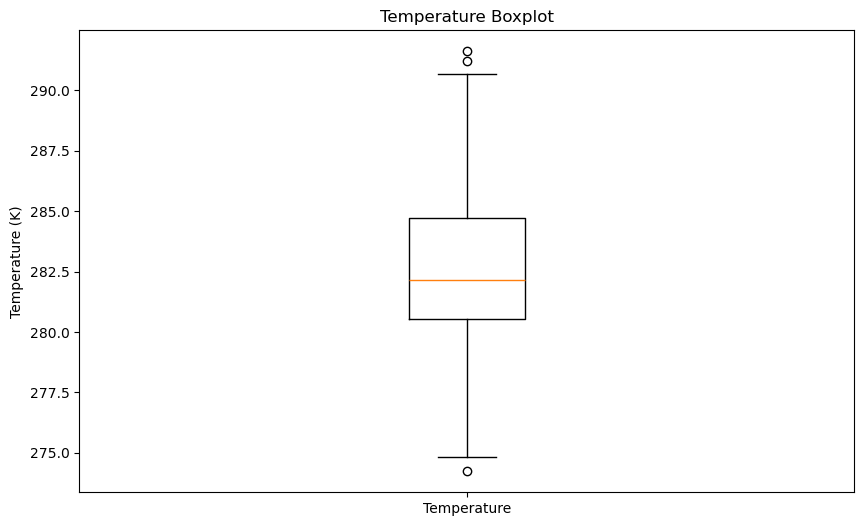

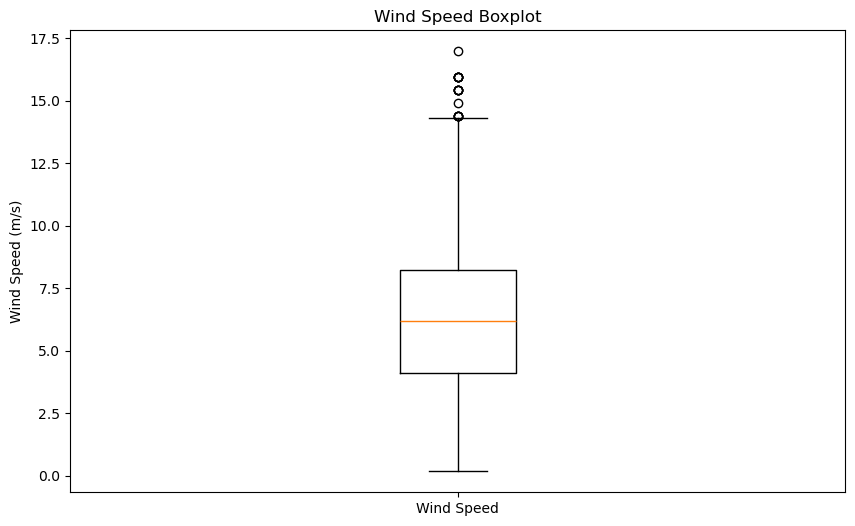

In [16]:
# Box diagram of temperature
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['temperature'].dropna())
plt.title('Temperature Boxplot')
plt.ylabel('Temperature (K)')
plt.xticks([1], ['Temperature'])
plt.show()

# Box diagram of windSpeed
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['wind_speed'].dropna())
plt.title('Wind Speed Boxplot')
plt.ylabel('Wind Speed (m/s)')
plt.xticks([1], ['Wind Speed'])
plt.show()


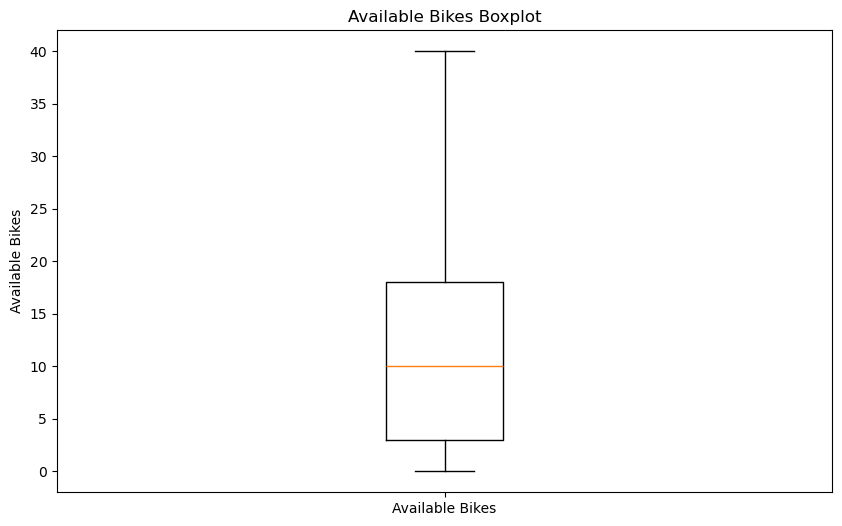

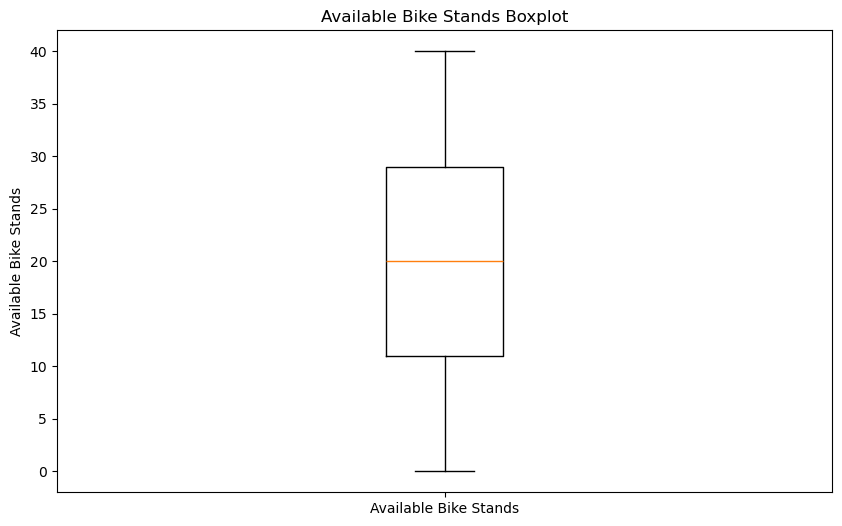

In [17]:
# The box diagram of the bicycle is available
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bikes'].dropna())
plt.title('Available Bikes Boxplot')
plt.ylabel('Available Bikes')
plt.xticks([1], ['Available Bikes'])
plt.show()

# Box map of available parking Spaces
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bike_stands'].dropna())
plt.title('Available Bike Stands Boxplot')
plt.ylabel('Available Bike Stands')
plt.xticks([1], ['Available Bike Stands'])
plt.show()


All good!!!! 

In order to more accurately match weather conditions, the weather data is temporally interpolated to create a denser time series dataset. Next, the interpolated weather data was combined with the bike availability data by last_update and number (station number). In this way, each bike data point will have a corresponding weather condition.况。

In [18]:
# Defines a list of category type columns
category_columns = ['weather_main', 'weather_description']

# Make sure the 'last_update' column is part of the DataFrame
if 'last_update' not in df_weather_filtered.columns:
    df_weather_filtered = df_weather_filtered.reset_index()

# Convert 'last_update' to the datetime type, where.loc is used to avoid SettingWithCopyWarning
df_weather_filtered.loc[:, 'last_update'] = pd.to_datetime(df_weather_filtered.loc[:, 'last_update'])

# Select numeric columns for interpolation
df_weather_numerical = df_weather_filtered.set_index('last_update')[weather_numerical_columns]
df_weather_interpolated = df_weather_numerical.interpolate(method='time').reset_index()

# Use.ffill() directly for forward fill to avoid FutureWarning
df_weather_filtered.loc[:, category_columns] = df_weather_filtered.loc[:, category_columns].ffill()

# Merge the categorical data back into the interpolated numerical data
df_weather_final = pd.merge(df_weather_interpolated, df_weather_filtered.loc[:, ['last_update'] + category_columns].drop_duplicates(), on='last_update', how='left')

# show the result to check
print(df_weather_final.head())


          last_update  temperature  feels_like  pressure  humidity  \
0 2024-02-28 00:26:21       278.85      276.10    1018.0      80.0   
1 2024-02-28 00:55:00       278.87      276.13    1018.0      80.0   
2 2024-02-28 01:27:46       278.97      276.58    1018.0      80.0   
3 2024-02-28 01:58:16       279.26      276.93    1017.0      80.0   
4 2024-02-28 02:27:23       279.29      276.64    1017.0      80.0   

   visibility  wind_speed  wind_deg  clouds_all weather_main  \
0     10000.0        3.60     210.0        40.0       Clouds   
1     10000.0        3.60     210.0        40.0       Clouds   
2     10000.0        3.09     200.0        40.0       Clouds   
3     10000.0        3.09     200.0        75.0         Rain   
4     10000.0        3.60     210.0        75.0         Rain   

  weather_description  
0    scattered clouds  
1    scattered clouds  
2    scattered clouds  
3          light rain  
4          light rain  


In [19]:
# Sort the two Dataframes by last_update
df_availability_sorted = df_availability_filtered.sort_values('last_update')
df_weather_sorted = df_weather_final.sort_values('last_update')

# Use merge_asof to find the most recent time record to merge
# We use nearest, so that the nearest can be found regardless of whether the timestamp is first or last
df_combined = pd.merge_asof(df_availability_sorted, df_weather_sorted,
                            on='last_update', direction='nearest')

print(df_combined.head())


   number  available_bikes  available_bike_stands         last_update  \
0      13                0                     30 2024-02-28 00:00:00   
1      59                7                     13 2024-02-28 00:00:02   
2     103                8                     32 2024-02-28 00:00:02   
3      73                7                     23 2024-02-28 00:00:06   
4      22               10                     10 2024-02-28 00:00:07   

   temperature  feels_like  pressure  humidity  visibility  wind_speed  \
0       278.85       276.1    1018.0      80.0     10000.0         3.6   
1       278.85       276.1    1018.0      80.0     10000.0         3.6   
2       278.85       276.1    1018.0      80.0     10000.0         3.6   
3       278.85       276.1    1018.0      80.0     10000.0         3.6   
4       278.85       276.1    1018.0      80.0     10000.0         3.6   

   wind_deg  clouds_all weather_main weather_description  
0     210.0        40.0       Clouds    scattered clouds 

In [20]:
# Print 5 random rows of data for verification
print(df_combined.sample(5))

        number  available_bikes  available_bike_stands         last_update  \
699858     103                2                     38 2024-04-02 21:48:17   
895575     111                7                     33 2024-04-12 18:44:21   
883599      71                0                     39 2024-04-12 06:11:16   
654121      71                1                     39 2024-03-31 14:01:32   
658627      87               12                     26 2024-03-31 19:25:12   

        temperature  feels_like  pressure  humidity  visibility  wind_speed  \
699858       281.59      278.35     996.0      94.0     10000.0        6.17   
895575       287.82      287.48    1021.0      82.0     10000.0        8.75   
883599       285.85      285.42    1022.0      86.0     10000.0        4.63   
654121       285.81      285.12     993.0      76.0     10000.0        8.75   
658627       282.94      279.90     992.0      83.0     10000.0        6.71   

        wind_deg  clouds_all weather_main weather_descri

In [21]:
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967368 entries, 0 to 967367
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 967368 non-null  int64         
 1   available_bikes        967368 non-null  int64         
 2   available_bike_stands  967368 non-null  int64         
 3   last_update            967368 non-null  datetime64[ns]
 4   temperature            967368 non-null  float64       
 5   feels_like             967368 non-null  float64       
 6   pressure               967368 non-null  float64       
 7   humidity               967368 non-null  float64       
 8   visibility             967368 non-null  float64       
 9   wind_speed             967368 non-null  float64       
 10  wind_deg               967368 non-null  float64       
 11  clouds_all             967368 non-null  float64       
 12  weather_main           967368 non-null  obje

### EDA

E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


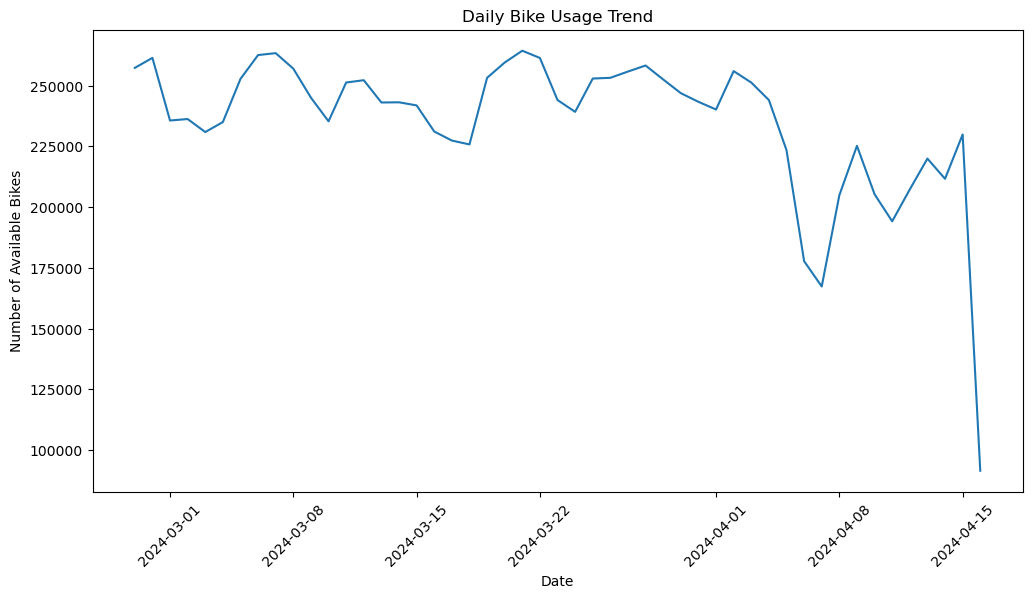

In [22]:
# Chart the trend of bicycle usage by day
df_combined['date'] = df_combined['last_update'].dt.date
daily_bikes = df_combined.groupby('date')['available_bikes'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='available_bikes', data=daily_bikes)
plt.title('Daily Bike Usage Trend')
plt.xlabel('Date')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()

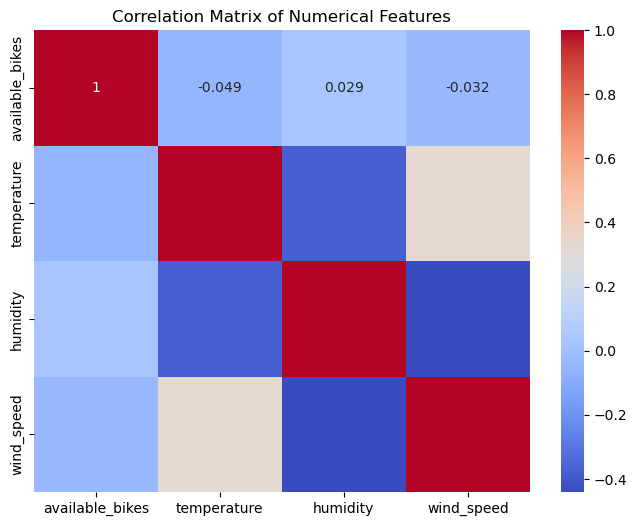

In [23]:
# Calculate correlations between numerical variables
correlation_matrix = df_combined[['available_bikes', 'temperature', 'humidity', 'wind_speed']].corr()

# Draw a correlation heat map
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


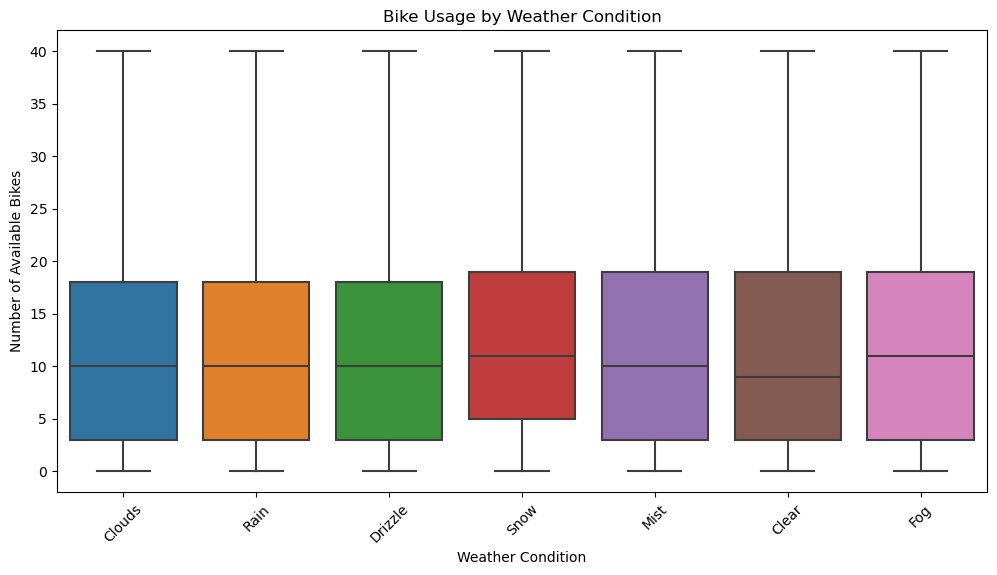

In [24]:
# Analyze bicycle usage in different weather conditions
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather_main', y='available_bikes', data=df_combined)
plt.title('Bike Usage by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()


Temperature and bike usage

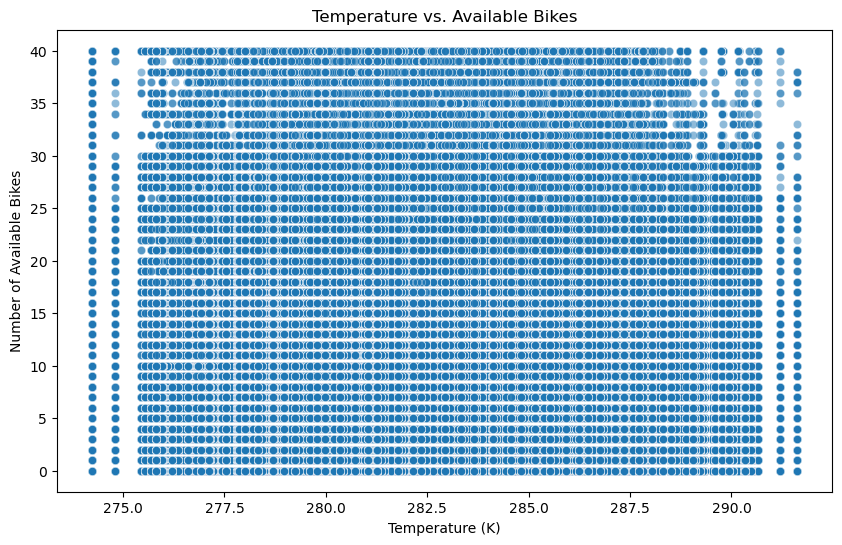

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Temperature vs. Available Bikes')
plt.xlabel('Temperature (K)')
plt.ylabel('Number of Available Bikes')
plt.show()


Humidity and bike usage

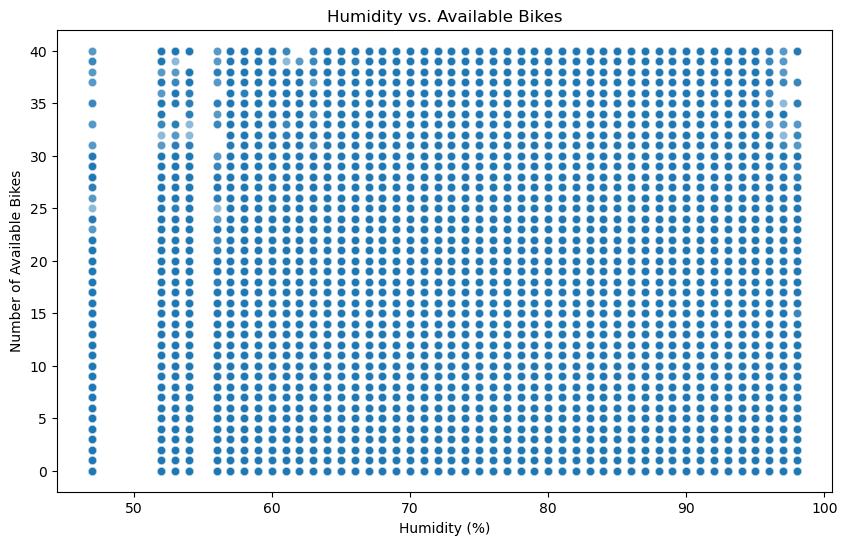

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='humidity', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Humidity vs. Available Bikes')
plt.xlabel('Humidity (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


Wind speed and bicycle usage
Assess the relationship between wind speed and bicycle use to determine whether strong winds reduce bicycle use.

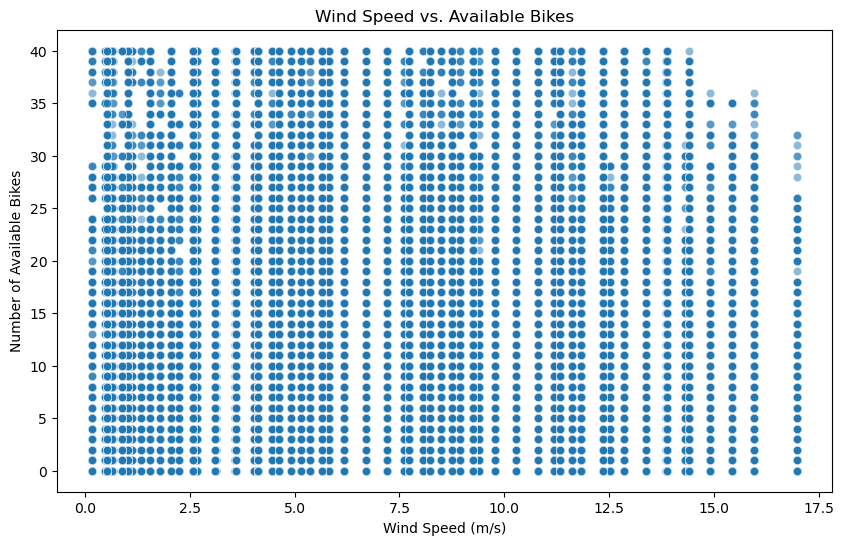

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Wind Speed vs. Available Bikes')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Number of Available Bikes')
plt.show()


Cloud cover and bicycle usage
Explore the relationship between cloud cover and bike usage to see how people tend to use their bikes on cloudy or sunny days.

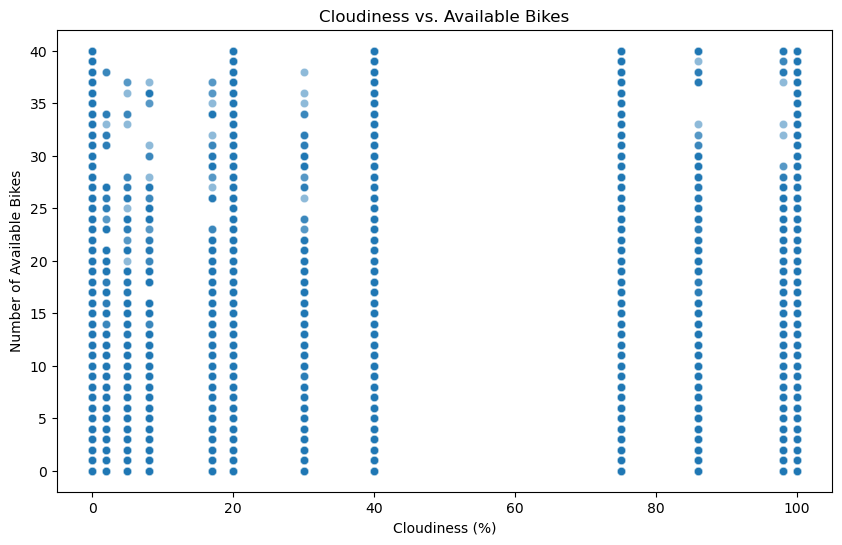

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='clouds_all', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Cloudiness vs. Available Bikes')
plt.xlabel('Cloudiness (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


### Feature engineering

In [29]:
# Extract the time feature from the last_update
df_combined['hour'] = df_combined['last_update'].dt.hour
df_combined['day_of_week'] = df_combined['last_update'].dt.dayofweek
df_combined['is_weekend'] = df_combined['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_combined['is_peak_hour'] = df_combined['hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)


In [30]:
one_hot = OneHotEncoder()
weather_main_encoded = one_hot.fit_transform(df_combined[['weather_main']]).toarray()
weather_columns = one_hot.get_feature_names_out(['weather_main'])
df_weather_encoded = pd.DataFrame(weather_main_encoded, columns=weather_columns)
with open('one_hot_encoder.pickle', 'wb') as file:
    pickle.dump(one_hot, file)

In [31]:
df_combined = pd.concat([df_combined.reset_index(drop=True), df_weather_encoded.reset_index(drop=True)], axis=1)

In [32]:
df_combined['feels_like_temp'] = df_combined['temperature'] - ((100 - df_combined['humidity']) / 5)

In [33]:
print(df_combined.info())
print(df_combined.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967368 entries, 0 to 967367
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 967368 non-null  int64         
 1   available_bikes        967368 non-null  int64         
 2   available_bike_stands  967368 non-null  int64         
 3   last_update            967368 non-null  datetime64[ns]
 4   temperature            967368 non-null  float64       
 5   feels_like             967368 non-null  float64       
 6   pressure               967368 non-null  float64       
 7   humidity               967368 non-null  float64       
 8   visibility             967368 non-null  float64       
 9   wind_speed             967368 non-null  float64       
 10  wind_deg               967368 non-null  float64       
 11  clouds_all             967368 non-null  float64       
 12  weather_main           967368 non-null  obje

### Model and Prediction

In [34]:
# Prepare feature matrix X and target variables y, retaining station numbers for association with specific stations post-prediction
X = df_combined.drop(['available_bikes', 'available_bike_stands', 'last_update', 'weather_main', 'weather_description'], axis=1)
X = X.select_dtypes(include=[np.number])  # Ensure only numeric columns are included

# Target variables
y_bikes = df_combined['available_bikes']
y_stands = df_combined['available_bike_stands']

# Dataset splitting
X_train_bikes, X_test_bikes, y_train_bikes, y_test_bikes = train_test_split(X, y_bikes, test_size=0.2, random_state=42)
X_train_stands, X_test_stands, y_train_stands, y_test_stands = train_test_split(X, y_stands, test_size=0.2, random_state=42)

##### Test 4 models and choose best one(but should be small)

In [35]:
# Initialization model
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Trees": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Initialization of models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Trees": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train the model and evaluate it for Bikes
results_bikes = []
for name, model in models.items():
    model.fit(X_train_bikes, y_train_bikes)  # train the model on bike data
    y_pred_bikes = model.predict(X_test_bikes)  # predict bike data

    mse_bikes = mean_squared_error(y_test_bikes, y_pred_bikes)  # Calculate the mean squared error for bikes
    rmse_bikes = np.sqrt(mse_bikes)  # Calculate root-mean-square error for bikes
    r2_bikes = r2_score(y_test_bikes, y_pred_bikes)  # Calculate the R² fraction for bikes

    results_bikes.append((name, rmse_bikes, r2_bikes))
    print(f"{name} - Bikes RMSE: {rmse_bikes:.2f}, R2: {r2_bikes:.2f}")

# Train the model and evaluate it for Stands
results_stands = []
for name, model in models.items():
    model.fit(X_train_stands, y_train_stands)  # train the model on stand data
    y_pred_stands = model.predict(X_test_stands)  # predict stand data

    mse_stands = mean_squared_error(y_test_stands, y_pred_stands)  # Calculate the mean squared error for stands
    rmse_stands = np.sqrt(mse_stands)  # Calculate root-mean-square error for stands
    r2_stands = r2_score(y_test_stands, y_pred_stands)  # Calculate the R² fraction for stands

    results_stands.append((name, rmse_stands, r2_stands))
    print(f"{name} - Stands RMSE: {rmse_stands:.2f}, R2: {r2_stands:.2f}")

Linear Regression - Bikes RMSE: 9.80, R2: 0.01
Decision Tree - Bikes RMSE: 1.50, R2: 0.98
Random Forest - Bikes RMSE: 1.33, R2: 0.98
Gradient Boosting Trees - Bikes RMSE: 8.59, R2: 0.24
Linear Regression - Stands RMSE: 10.61, R2: 0.09
Decision Tree - Stands RMSE: 1.49, R2: 0.98
Random Forest - Stands RMSE: 1.34, R2: 0.99
Gradient Boosting Trees - Stands RMSE: 8.69, R2: 0.39


a.

### Analysis for Available Bikes

1. **Linear Regression**
   - **RMSE**: 9.80
   - **R²**: 0.01
   - **Interpretation**: Poor model performance; it has a high error and explains almost none of the variance in bike availability, suggesting that linear assumptions might not hold for this dataset.

2. **Decision Tree**
   - **RMSE**: 1.50
   - **R²**: 0.98
   - **Interpretation**: Excellent performance with very high accuracy and model explains nearly all the variance, indicating a good fit.

3. **Random Forest**
   - **RMSE**: 1.33
   - **R²**: 0.98
   - **Interpretation**: Similar to Decision Tree, Random Forest provides excellent prediction accuracy and explains nearly all the variance in bike availability.

4. **Gradient Boosting Trees**
   - **RMSE**: 8.59
   - **R²**: 0.24
   - **Interpretation**: Moderate to poor performance; it has a high error rate and low explanation of variance, suggesting Gradient Boosting may not be suitable or is overfitting/underfitting the data.

### Analysis for Available Bike Stands

1. **Linear Regression**
   - **RMSE**: 10.61
   - **R²**: 0.09
   - **Interpretation**: Very poor fit similar to its performance on bikes, indicating that the model fails to capture the complexities or nonlinear relationships in the dataset for bike stands.

2. **Decision Tree**
   - **RMSE**: 1.49
   - **R²**: 0.98
   - **Interpretation**: Very good performance, accurate in predicting the number of available stands and explains almost all the variance.

3. **Random Forest**
   - **RMSE**: 1.34
   - **R²**: 0.99
   - **Interpretation**: Best performance among all models, offering the highest accuracy and explanation of variance in bike stand predictions.

4. **Gradient Boosting Trees**
   - **RMSE**: 8.69
   - **R²**: 0.39
   - **Interpretation**: Not as poor as Linear Regression but still relatively ineffective at predicting bike stand availability accurately.

### Recommendations

- **For Bikes**: The Decision Tree and Random Forest models are the best choices given their low RMSE and high R² values. Random Forest slightly edges out due to a lower RMSE, indicating it might be handling variance in the data slightly better.
- **For Stands**: Again, Decision Tree and Random Forest show superior performance. Random Forest might be the best model overall considering consistency acrodels, to ensure the models generalize well to new data.

In [36]:
# Train Decision Tree models
dt_bikes = DecisionTreeRegressor(random_state=42)
dt_bikes.fit(X_train_bikes, y_train_bikes)
dt_stands = DecisionTreeRegressor(random_state=42)
dt_stands.fit(X_train_stands, y_train_stands)

DecisionTreeRegressor(random_state=42)

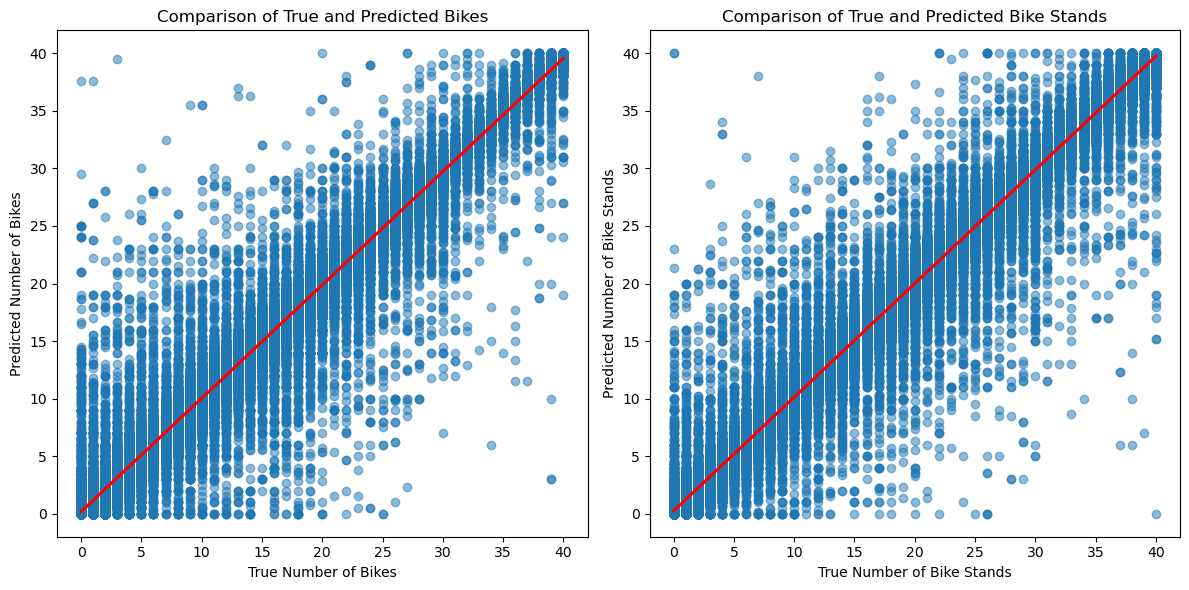

In [37]:
# Perform predictions
y_pred_bikes_dt = dt_bikes.predict(X_test_bikes)
y_pred_stands_dt = dt_stands.predict(X_test_stands)

# Append predictions and true values to the test data for plotting
test_data_bikes = X_test_bikes.copy()
test_data_bikes['True Bikes'] = y_test_bikes
test_data_bikes['Predicted Bikes'] = y_pred_bikes_dt

test_data_stands = X_test_stands.copy()
test_data_stands['True Stands'] = y_test_stands
test_data_stands['Predicted Stands'] = y_pred_stands_dt

# Plotting
plt.figure(figsize=(12, 6))

# Plot for bikes
plt.subplot(1, 2, 1)
sns.regplot(x='True Bikes', y='Predicted Bikes', data=test_data_bikes, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Comparison of True and Predicted Bikes')
plt.xlabel('True Number of Bikes')
plt.ylabel('Predicted Number of Bikes')

# Plot for stands
plt.subplot(1, 2, 2)
sns.regplot(x='True Stands', y='Predicted Stands', data=test_data_stands, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Comparison of True and Predicted Bike Stands')
plt.xlabel('True Number of Bike Stands')
plt.ylabel('Predicted Number of Bike Stands')

plt.tight_layout()
plt.show()

# Performance evaluation
rmse_bikes_dt = mean_squared_error(y_test_bikes, y_pred_bikes_dt, squared=False)
rmse_stands_dt = mean_squared_error(y_test_stands, y_pred_stands_dt, squared=False)

In [38]:
print(f"RMSE for available bikes prediction with Decision Tree: {rmse_bikes_dt:.2f}")
print(f"RMSE for available bike stands prediction with Decision Tree: {rmse_stands_dt:.2f}")

RMSE for available bikes prediction with Decision Tree: 1.50
RMSE for available bike stands prediction with Decision Tree: 1.49


In [35]:
with open('dt_bikes_model.pickle', 'wb') as f:
    pickle.dump(dt_bikes, f)

with open('dt_stands_model.pickle', 'wb') as f:
    pickle.dump(dt_stands, f)